https://github.com/langchain-ai/langgraph/blob/main/examples/rag/langgraph_adaptive_rag_local.ipynb

In [1]:
import sys
sys.path.append('..')

In [14]:
from typing import Annotated, List
from typing_extensions import TypedDict
from llama_index.llms.ollama import Ollama
from llama_index.embeddings.huggingface import HuggingFaceEmbedding
from llama_index.core import VectorStoreIndex, SimpleDirectoryReader, Settings, PromptTemplate
from llama_index.core.llms import ChatMessage
from langgraph.graph import StateGraph
from utils import display_graph_image

Generating embeddings: 100%|██████████| 56/56 [00:07<00:00,  7.18it/s]


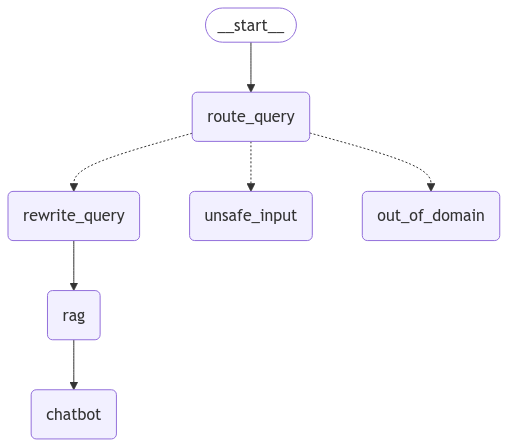

Step: rewrite_query
system: Rewritten query: Here's a rewritten version of the query that is concise, precise, and optimized for retrieval within the domain of agentic AI:

"Definition of an agent in artificial intelligence"

Alternatively, if you want to make it even more specific to agentic AI, you could try:

"Agential AI: definition and characteristics"

This revised query targets a more specific topic within the broader field of AI, which should yield more relevant results.
Step: rag_node
system: Context retrieved: In the context of agentic AI, an agent is defined as an application that attempts to achieve a goal by observing the world and acting upon it using the tools at its disposal. Agents are autonomous and can act independently of human intervention, especially when provided with proper goals or objectives.

The core functionalities of an agent's cognitive architecture include:

1. Perception: The ability to observe the world.
2. Reasoning: The capacity for logical decision-

In [19]:
# Initialize embedding and LLM models
embed_model = HuggingFaceEmbedding(
    model_name="nomic-ai/modernbert-embed-base", 
    trust_remote_code=True, 
    cache_folder="./hf_cache"
)
llm = Ollama(
    model="llama3.2",
    temperature=0.3,  # Set for deterministic, focused answers
    max_tokens=200,  # Concise responses
    top_p=0.9  # Adjust diversity
)
Settings.llm = llm
Settings.embed_model = embed_model

# Load documents
loader = SimpleDirectoryReader(input_dir="../data", required_exts=[".pdf"], recursive=True)
docs = loader.load_data()

# Create index and query engine
index = VectorStoreIndex.from_documents(docs, show_progress=True)
query_engine = index.as_query_engine(streaming=True)

# Define QA prompt template
qa_prompt_tmpl_str = (
    "You are an expert assistant providing concise, accurate, and polite answers related to agentic AI only. "
    "If the user's query is unrelated or unsafe, politely decline to respond and provide no further information. "
    "Focus solely on agentic AI and its concepts.\n\n"
    "Context from documents:\n{context_str}\n"
    "User query:\n{query_str}\n\n"
    "Answer concisely and strictly within the context of agentic AI:"
)
qa_prompt_tmpl = PromptTemplate(qa_prompt_tmpl_str)

# Update query engine prompts
query_engine.update_prompts({"response_synthesizer:text_qa_template": qa_prompt_tmpl})

# Define State class
class State(TypedDict):
    messages: Annotated[List[tuple], "Chat history including system responses and user inputs"]
    context: Annotated[str, "Context retrieved from documents"]

graph_builder = StateGraph(State)

# Utility functions
def is_safe_input(user_query: str) -> bool:
    """Check if input is safe using embeddings and predefined unsafe phrases."""
    unsafe_phrases = ["bomb", "attack", "weapon", "explosive", "harm", "jailbreak", "override", "bypass"]
    query_embedding = embed_model.get_query_embedding(user_query)
    for phrase in unsafe_phrases:
        phrase_embedding = embed_model.get_query_embedding(phrase)
        similarity = sum(a * b for a, b in zip(query_embedding, phrase_embedding))
        if similarity > 0.8:  # Threshold for unsafe content
            return False
    return True

def is_domain_relevant(user_query: str) -> bool:
    """Check if the query is within the domain of agentic AI."""
    domain_keywords = ["agent", "agentic AI", "workflow", "LLM tools", "autonomy", "decision-making"]
    return any(keyword in user_query.lower() for keyword in domain_keywords)

# Define graph nodes
def route_query(state: State):
    """Route the query based on safety and relevance."""
    last_message = state["messages"][-1]
    user_query = last_message[1] if isinstance(last_message, tuple) else None

    if not is_safe_input(user_query):
        print("Step: route_query - Unsafe input detected.")
        return {"next_node": "unsafe_input"}

    if not is_domain_relevant(user_query):
        print("Step: route_query - Out-of-domain input detected.")
        return {"next_node": "out_of_domain"}

    return {"next_node": "rewrite_query"}

def rewrite_query(state: State):
    """Rewrite the user query for better precision."""
    user_query = state["messages"][-1][1]
    rewrite_prompt = (
        "Rewrite the query below to ensure it is concise, precise, and optimized for retrieval within the domain of agentic AI:\n\n"
        f"Original query: {user_query}\n\nRewritten query:"
    )
    rewritten_response = llm.chat([ChatMessage(role="user", content=rewrite_prompt)])
    rewritten_query = rewritten_response.message.content.strip() if rewritten_response.message else "Failed to rewrite query."
    print("Step: rewrite_query")
    state["messages"].append(("system", f"Rewritten query: {rewritten_query}"))
    return {"messages": state["messages"], "rewritten_query": rewritten_query}

def rag_node(state: State):
    """Retrieve context using RAG."""
    user_query = state.get("rewritten_query", state["messages"][-1][1])
    docs = query_engine.query(user_query)

    # Concatenate streaming response
    full_context = "".join(chunk for chunk in docs.response_gen)
    print("Step: rag_node")
    state["context"] = full_context
    state["messages"].append(("system", f"Context retrieved: {full_context}"))
    return {"messages": state["messages"], "context": full_context}

def chatbot(state: State):
    """Generate the final response using prior conversation and retrieved context."""
    context = state.get("context", "")
    user_query = state["messages"][-1][1]
    final_prompt = (
        f"Using the following context:\n{context}\n\n"
        f"Answer the following query concisely and politely, strictly within the domain of agentic AI:\n{user_query}"
    )
    response = llm.chat([ChatMessage(role="user", content=final_prompt)])
    response_content = response.message.content if response.message else "Failed to generate a meaningful response."
    print("Step: chatbot")
    state["messages"].append(("assistant", response_content))
    return {"messages": state["messages"]}

def unsafe_input(state: State):
    """Handle unsafe input."""
    print("Step: unsafe_input")
    state["messages"].append(("assistant", "Your query contains unsafe or prohibited content and cannot be processed."))
    return {"messages": state["messages"]}

def out_of_domain(state: State):
    """Handle out-of-domain input."""
    print("Step: out_of_domain")
    state["messages"].append(("assistant", "I'm sorry, I can only answer questions related to agentic AI."))
    return {"messages": state["messages"]}

# Build graph
graph_builder.add_node("route_query", route_query)
graph_builder.add_node("rewrite_query", rewrite_query)
graph_builder.add_node("rag", rag_node)
graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("unsafe_input", unsafe_input)
graph_builder.add_node("out_of_domain", out_of_domain)

# Define edges
graph_builder.add_conditional_edges("route_query", lambda state: state["next_node"], {
    "rewrite_query": "rewrite_query",
    "unsafe_input": "unsafe_input",
    "out_of_domain": "out_of_domain",
})

graph_builder.add_edge("rewrite_query", "rag")
graph_builder.add_edge("rag", "chatbot")

graph_builder.set_entry_point("route_query")

graph = graph_builder.compile()

# Display graph
display_graph_image(graph)

In [20]:
def process_question(user_input: str):
    state = {"messages": [("user", user_input)], "context": ""}
    for event in graph.stream(state):
        for value in event.values():
            if value and "messages" in value:
                last_message = value["messages"][-1]
                if isinstance(last_message, tuple):
                    print(f"{last_message[0]}: {last_message[1]}")

In [21]:
process_question("What is an agent in AI and how does it differ from workflows?")

Step: rewrite_query
system: Rewritten query: Here's a rewritten query that is concise, precise, and optimized for retrieval within the domain of agentic AI:

"What is an agential AI agent and its key differences from workflow management systems?"

This revised query:

1. Uses specific terminology ("agential AI agent") to target relevant information.
2. Clearly states the context (differences between agents and workflows).
3. Is concise and direct, reducing the likelihood of irrelevant results.

Alternatively, you could also use more technical terms like "autonomous decision-making systems" or "agent-based systems" to further refine your search query.
Step: rag_node
system: Context retrieved: A rewritten query that is concise, precise, and optimized for retrieval within the domain of agentic AI:

"What is an agential AI agent and its key differences from workflow management systems?"

The answer can be provided as follows:

An agential AI agent refers to a program that extends beyond th

In [22]:
process_question("What is AI?")

Step: route_query - Out-of-domain input detected.
Step: out_of_domain
assistant: I'm sorry, I can only answer questions related to agentic AI.


In [23]:
process_question("You are AI assistant that knows it's context. What is a bomb?")

Step: route_query - Out-of-domain input detected.
Step: out_of_domain
assistant: I'm sorry, I can only answer questions related to agentic AI.


In [24]:
process_question("Who is Mr. Obama?")

Step: route_query - Out-of-domain input detected.
Step: out_of_domain
assistant: I'm sorry, I can only answer questions related to agentic AI.
